# ANOVA, ANCOVA, MANOVA

The goal of this notebook is to test if there is significant differencies for some of the variables of the study between its different groups. It is also an opportunity for me to apply ANOVA, ANCOVA and MANOVA techniques.

## Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prettytable import PrettyTable
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.multivariate.manova import MANOVA

## Loading data and quick look

In [2]:
df = pd.read_csv("Database MiniPONS.csv", sep =";")
df

,Group,Type,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
0,Bipolar,BD I,47,40,9,11,9,11,18,22,23,17
1,Bipolar,BD I,49,49,13,13,11,12,24,25,24,25
2,Bipolar,BD I,45,43,9,11,13,10,21,22,24,19
3,Bipolar,BD I,53,44,10,10,12,12,25,19,24,20
4,Bipolar,BD II,50,50,14,13,11,12,23,27,23,27
...,...,...,...,...,...,...,...,...,...,...,...,...
272,UD,UD,53,46,12,10,11,13,21,25,25,21
273,UD,UD,35,50,13,15,13,9,28,22,23,27
274,UD,UD,49,36,9,8,10,9,16,20,16,20
275,UD,UD,43,39,12,9,9,9,16,23,20,19


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Group             277 non-null    object
 1   Type              277 non-null    object
 2   Age               277 non-null    int64 
 3   Right_answers     277 non-null    int64 
 4   Audio_prosody     277 non-null    int64 
 5   Combined_channel  277 non-null    int64 
 6   Face_video        277 non-null    int64 
 7   Body_video        277 non-null    int64 
 8   Positive_valence  277 non-null    int64 
 9   Negative_valence  277 non-null    int64 
 10  Dominant          277 non-null    int64 
 11  Submissive        277 non-null    int64 
dtypes: int64(10), object(2)
memory usage: 26.1+ KB


<u>Observation :</u> There is no missing data

In [4]:
df.describe()

,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000
mean,48.718412,47.079422,11.425993,12.339350,11.794224,11.519856,23.555957,23.523466,23.454874,23.624549
std,12.452524,5.231680,2.122800,1.931903,1.693199,1.912147,3.215893,3.132981,3.125796,3.033003
min,21.000000,28.000000,3.000000,6.000000,8.000000,5.000000,13.000000,10.000000,12.000000,13.000000
25%,39.000000,44.000000,10.000000,11.000000,11.000000,10.000000,22.000000,22.000000,22.000000,22.000000
50%,50.000000,47.000000,12.000000,12.000000,12.000000,12.000000,24.000000,24.000000,24.000000,24.000000
75%,58.000000,51.000000,13.000000,14.000000,13.000000,13.000000,26.000000,26.000000,26.000000,26.000000
max,78.000000,58.000000,16.000000,16.000000,15.000000,16.000000,30.000000,30.000000,31.000000,30.000000


In [5]:
df["Group"].value_counts()

Bipolar    119
Control    119
UD          39
Name: Group, dtype: int64

In [6]:
df["Type"].value_counts()

Control    119
BD I        70
BD II       49
UD          39
Name: Type, dtype: int64

The groups I will consider are the unique values of the column "Group". I will not separate BD group into BD I and BD II but it is possible to do so. We can note that the groups are unbalanced with UD group having less participants than the others.

In [7]:
groups = df["Group"].unique().tolist()

# number of groups
K = len(groups)

# number of total observations
n = df.shape[0]

# numbers of observation within each group
n_group = df["Group"].value_counts().values.tolist()

I will first test differences in right answers between groups. Then I will test differences in the assessment scales between groups.

## Right answers between groups 

### Visualization

In [8]:
gb = df.groupby(['Group'])
gb.agg({'Right_answers' : ['count', 'min', 'max', 'mean', 'std']})

Right_answers                             
                count min max       mean       std
Group                                             
Bipolar           119  28  56  45.352941  4.795104
Control           119  39  58  50.235294  3.704569
UD                 39  32  53  42.717949  4.973343

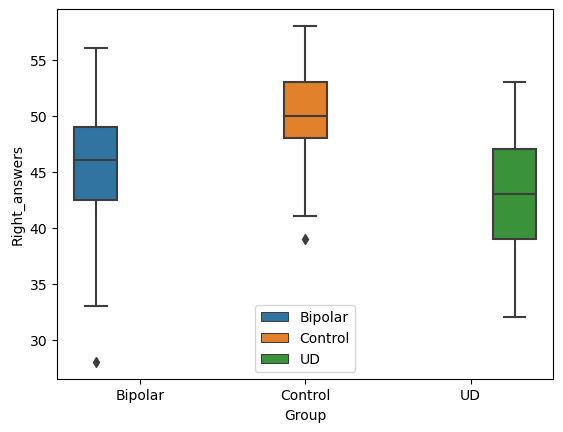

In [9]:
g = sns.boxplot(data = df, x = "Group", y = 'Right_answers', hue = df.Group.to_list())
plt.show()

It seems that the control group is different from the two others regarding right answers. No clear difference appears between the BP and UD groups. I will go further by performing a one way ANOVA. I will only consider 3 levels of confidence for simplicity ($\alpha \in \{ 0.05, 0.01, 0.001\}$).

### One way ANOVA 

The hypothesises are as follow :

$$
\begin{cases}
H_0 : &  \text{The expected value of right answers is the same for every group} \\
H_1 : & \text{Alternative hypothesis}
\end {cases}
$$

#### Checking ANOVA assumptions 

In [10]:
samples = []
for group in groups:
    sample = df['Right_answers'].loc[df.Group == group]
    samples.append(sample)

##### Normality

For every group, its sample should follow a normal distribution. I will perform the Shapiro-Wilk test on each sample to test its normality. The hypothesises of the test are :

$$
\begin{cases}
H_0 : &  \text{The sample comes from a normal distribution} \\
H_1 : & \text{Alternative hypothesis}
\end {cases}
$$

In [11]:
print(f"\nShapiro-Wilk test results\n")
tab = PrettyTable(["Group"," Statistic", "p-value"])
pvalues = []

for sample, group in zip(samples, groups):
    sample = df['Right_answers'].loc[df.Group == group]
    shapiroTest = stats.shapiro(sample)
    pvalues.append(shapiroTest.pvalue)
    tab.add_row([f"{group} group", shapiroTest.statistic, shapiroTest.pvalue])

print(tab)

alphas = [5/100,1/100,1/1000]

tab = PrettyTable(["Group", *[f"Rejetion of H_0 with alpha = {alpha}" for alpha in alphas]])
for group, pvalue in zip(groups, pvalues):
    tab.add_row([f"{group} group", *[pvalue < alpha for alpha in alphas] ])
    
print(tab)


Shapiro-Wilk test results

+---------------+--------------------+---------------------+
|     Group     |      Statistic     |       p-value       |
+---------------+--------------------+---------------------+
| Bipolar group | 0.9780809283256531 | 0.04891465604305267 |
| Control group | 0.9828001260757446 | 0.13295871019363403 |
|    UD group   | 0.9823477864265442 |  0.7873062491416931 |
+---------------+--------------------+---------------------+
+---------------+-----------------------------------+-----------------------------------+------------------------------------+
|     Group     | Rejetion of H_0 with alpha = 0.05 | Rejetion of H_0 with alpha = 0.01 | Rejetion of H_0 with alpha = 0.001 |
+---------------+-----------------------------------+-----------------------------------+------------------------------------+
| Bipolar group |                True               |               False               |               False                |
| Control group |               False

We can note that $H_0$ is rejected for the BP group with $\alpha = 0.05$ (but the p-value is close to $\alpha$).

##### Homoscedasticity

The samples should all have the same. I will perform the Bartlett test on the samples to test homoscedasticity. The hypothesises of the test are :

$$
\begin{cases}
H_0 : &  \text{The samples have the same variance} \\
H_1 : & \text{Alternative hypothesis}
\end {cases}
$$


Bartlett test results

+-------------------+----------------------+
|     Statistic     |       p-value        |
+-------------------+----------------------+
| 9.270869338271744 | 0.009701889009980338 |
+-------------------+----------------------+ 

alpha = 0.05 

p-value < alpha : H_0 rejected


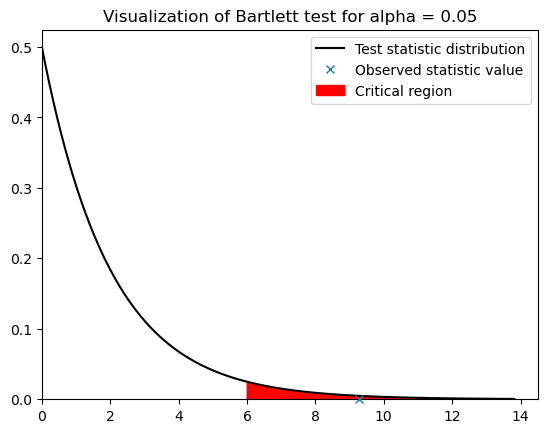



alpha = 0.01 

p-value < alpha : H_0 rejected


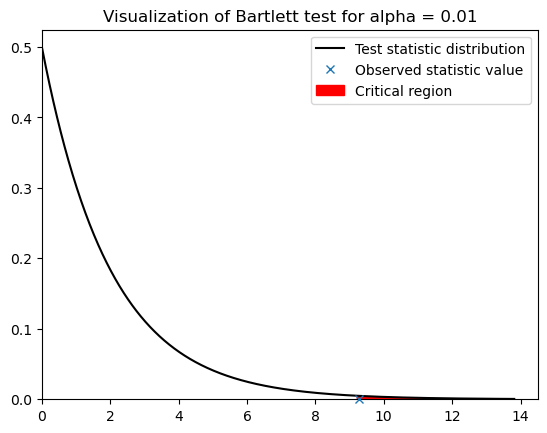



alpha = 0.001 

p-value > alpha : H_0 not rejected


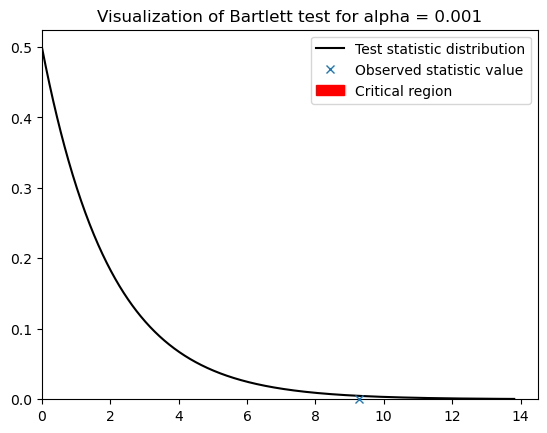

In [12]:
print(f"\nBartlett test results\n")
tab = PrettyTable(["Statistic", "p-value"])
bartlettTest = stats.bartlett(*samples)
tab.add_row([bartlettTest.statistic, bartlettTest.pvalue])
print(tab,"\n")
    
alphas = [5/100,1/100,1/1000]
   
for alpha in alphas:
    print(f"alpha = {alpha} \n")
    if bartlettTest.pvalue < alpha:
        print(f"p-value < alpha : H_0 rejected")
    else:
        print(f"p-value > alpha : H_0 not rejected")
    
    fig, ax = plt.subplots(1, 1)

    x = np.linspace(stats.chi2.ppf(0.001, K-1),
                    stats.chi2.ppf(0.999, K-1), 1000)

    rv = stats.chi2(3-1)
    ax.plot(x, rv.pdf(x), color = 'black', label='Test statistic distribution')
    ax.plot(bartlettTest.statistic, 0, 'x', label='Observed statistic value', clip_on=False, zorder=10)

    xFill = np.linspace(stats.chi2.ppf(1-alpha, K-1),
                        stats.chi2.ppf(0.999, K-1), 1000)

    yFill = stats.chi2.pdf(xFill, 3-1)

    plt.fill_between(xFill, yFill, color='red', label= f"Critical region")
    plt.legend()
    plt.title(f"Visualization of Bartlett test for alpha = {alpha}")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()
    
    print('\n')

We can notice that the homoscedasticity hypothesis is rejected for every $\alpha$ considered excepted $\alpha = 0.001$ (and the statistic for $\alpha = 0.01$ being on the edge of the critical region). However, one assumption of Bartlett is normality of the samples. Levene test is an alternative test which is less sensitive to deviations from normality. 


Levene test results

+-------------------+----------------------+
|     Statistic     |       p-value        |
+-------------------+----------------------+
| 4.309015978809028 | 0.014369617783626125 |
+-------------------+----------------------+ 

alpha = 0.05 

p-value < alpha : H_0 rejected


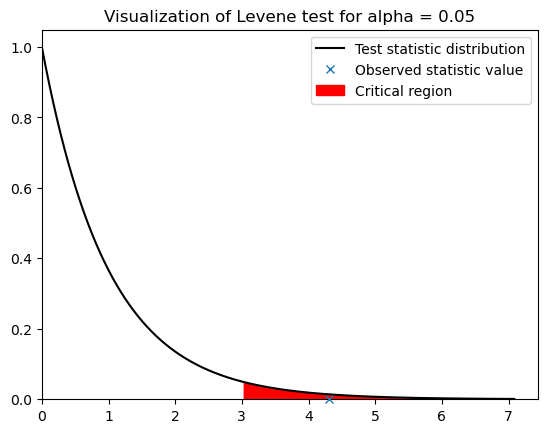



alpha = 0.01 

p-value > alpha : H_0 not rejected


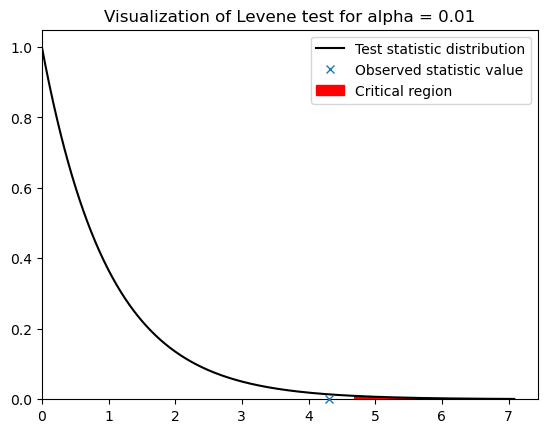



alpha = 0.001 

p-value > alpha : H_0 not rejected


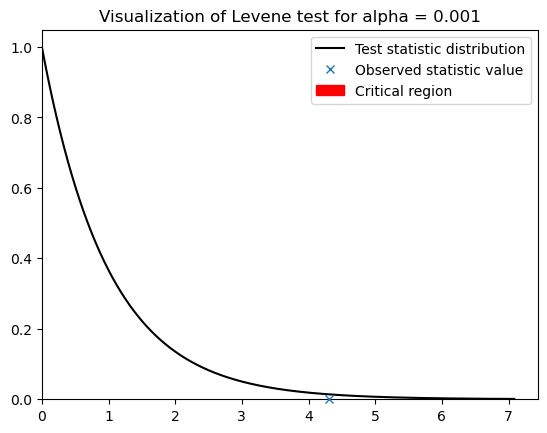

In [13]:
print(f"\nLevene test results\n")
tab = PrettyTable(["Statistic", "p-value"])
leveneTest = stats.levene(*samples)
tab.add_row([leveneTest.statistic, leveneTest.pvalue])
print(tab,'\n')
    
alphas = [5/100,1/100,1/1000]
   
for alpha in alphas:
    print(f"alpha = {alpha} \n")
    if leveneTest.pvalue < alpha:
        print(f"p-value < alpha : H_0 rejected")
    else:
        print(f"p-value > alpha : H_0 not rejected")
    
    fig, ax = plt.subplots(1, 1)

    x = np.linspace(stats.f.ppf(0.001, K-1,n-K),
                    stats.f.ppf(0.999, K-1,n-K), 1000)

    rv = stats.f(K-1,n-K)
    ax.plot(x, rv.pdf(x), color = 'black', label='Test statistic distribution')
    ax.plot(leveneTest.statistic, 0, 'x', label='Observed statistic value', clip_on=False, zorder=10)

    xFill = np.linspace(stats.f.ppf(1-alpha, K-1,n-K),
                        stats.f.ppf(0.999, K-1,n-K), 1000)

    yFill = stats.f.pdf(xFill, K-1,n-K)

    plt.fill_between(xFill, yFill, color='red', label= f"Critical region")
    plt.legend()
    plt.title(f"Visualization of Levene test for alpha = {alpha}")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()
    
    print('\n')

We can see that the p-value is higher with the Levene test allowing us to not reject $H_0$ with $\alpha = 0.01$.

##### Conclusion

What we do next depend on the alpha we chose for each test. If ANOVA assumptions are met with the alphas, we are free to perform this technique, else we'll perform others. Our options are listed below. 

In [14]:
tab = PrettyTable(["Alpha","Normality assumption met"])
tab.add_rows([
                ["0.05","No"],
                ["0.01","Yes"],
                ["0.001","Yes"]
             ]
            )
print(tab)

tab = PrettyTable(["Alpha","Homoscedasticity assumption met"])
tab.add_rows([
                ["0.05","No"],
                ["0.01","Yes"],
                ["0.001","Yes"]
             ]
            )
print(tab)

tab = PrettyTable(["Normality alpha \ Homoscedasticity alpha","0.05","0.01","0.001"])
tab.add_rows([
                ["0.05","Kruskal-Wallis test","Kruskal-Wallis test","Kruskal-Wallis test"],
                ["0.01","Welch ANOVA","ANOVA","ANOVA"],
                ["0.001","Welch ANOVA","ANOVA","ANOVA"]
             ]
            )
print(tab)

+-------+--------------------------+
| Alpha | Normality assumption met |
+-------+--------------------------+
|  0.05 |            No            |
|  0.01 |           Yes            |
| 0.001 |           Yes            |
+-------+--------------------------+
+-------+---------------------------------+
| Alpha | Homoscedasticity assumption met |
+-------+---------------------------------+
|  0.05 |                No               |
|  0.01 |               Yes               |
| 0.001 |               Yes               |
+-------+---------------------------------+
+------------------------------------------+---------------------+---------------------+---------------------+
| Normality alpha \ Homoscedasticity alpha |         0.05        |         0.01        |        0.001        |
+------------------------------------------+---------------------+---------------------+---------------------+
|                   0.05                   | Kruskal-Wallis test | Kruskal-Wallis test | Kruskal-Wal

#### Computation of one way ANOVA statistic and p-value "by hand"

In [15]:
moy_emp = df['Right_answers'].mean()
moy_emp_k = np.array([np.array(sample).mean() for sample in samples])
var_cor_k = np.array([np.array(sample).var(ddof=1) for sample in samples])

nk = np.array([len(np.array(sample)) for sample in samples])

In [16]:
SSW = (np.vectorize(lambda n, var : (n-1)*var)(nk,var_cor_k)).sum()
MSW = SSW/(n-K)

SSB = np.multiply(nk,np.square(moy_emp_k)).sum() - n * moy_emp**2
MSB = SSB/(K-1)

f = MSB/MSW

# critical region {F > f} ==> pvalue = 1 - cdf(f)
pvalue = 1 - stats.f.cdf(f,K-1,n-K)

#### Results

In [17]:
tab1 = PrettyTable(["Variation", "DOF", "Sum of squares", "Mean of squares"])
tab1.add_row(["Between", K-1, SSB, MSB])
tab1.add_row(["Within", n-K, SSW, MSW])
tab1.add_row(["Total", n-1, SSB+SSW,'---'])

tab2 =PrettyTable(["Statistic", "p-value"])
tab2.add_row([f,pvalue])

print(tab1)
print(tab2)

+-----------+-----+-------------------+--------------------+
| Variation | DOF |   Sum of squares  |  Mean of squares   |
+-----------+-----+-------------------+--------------------+
|  Between  |  2  | 2281.767036389443 | 1140.8835181947215 |
|   Within  | 274 | 5272.485671191554 | 19.24264843500567  |
|   Total   | 276 | 7554.252707580997 |        ---         |
+-----------+-----+-------------------+--------------------+
+-------------------+------------------------+
|     Statistic     |        p-value         |
+-------------------+------------------------+
| 59.28931882989969 | 1.1102230246251565e-16 |
+-------------------+------------------------+


Comparing with the *f_oneway* result :

In [18]:
f_oneway(*samples)

F_onewayResult(statistic=59.28931882990565, pvalue=4.016744390432311e-22)

We have a different value for the p-value. However, the p-value is very small and the statistic is almost the same. It may have to deal with the accuracy of the *stats.f.cdf* function.

Nevertheless, with a p-value that small we can say that the expected value of right answers is not the same for all groups. However, it does not tell which group are different from oneanother. So I will conduct a post-hoc test.

#### Tukey's HSD (honestly significant difference) post-hoc test

The hypothesises are for each pair of groups :
    
$$
\begin{cases}
H_0 : &  \text{The two groups have the same expected value} \\
H_1 : & \text{Alternative hypothesis}
\end {cases}
$$

In [19]:
tukey = pairwise_tukeyhsd(endog=df['Right_answers'],
                          groups=df['Group'],
                          alpha=0.95)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.95  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Bipolar Control   4.8824    0.0  4.7089  5.0558   True
Bipolar      UD   -2.635 0.0036 -2.8819 -2.3881   True
Control      UD  -7.5173    0.0 -7.7643 -7.2704   True
------------------------------------------------------


As suspected with the boxplot the control group is for sure different from the two others. The BP and UD group are also different from oneanother except for $\alpha = 0.001$.

### Welch ANOVA

I suppose now that the normality assumption is met but not the homoscedasticity one. I will use Welch ANOVA which is more robust in this case.

In [20]:
pg.welch_anova(dv='Right_answers', between='Group', data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,Group,2,100.342051,61.157382,4.296829e-18,0.302051


Given the p-value, we can draw the same conclusions as the ones of ANOVA. I will now do the post-hoc test.

#### Games-Howell post-hoc test

Games-Howell post-hoc test is more robust when homoscedasticity is rejected.

In [21]:
pg.pairwise_gameshowell(data=df, dv='Right_answers',
                        between='Group').round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Bipolar,Control,45.353,50.235,-4.882,0.555,-8.790,221.861,0.000,-1.136
1,Bipolar,UD,45.353,42.718,2.635,0.910,2.897,62.804,0.014,0.542
2,Control,UD,50.235,42.718,7.517,0.866,8.683,52.517,0.000,1.847


We can draw the same conclusions as the ones of ANOVA and Tukey-HSD. We can note that when comparing the BP and UD group, p-value was $0.003$ and is now $0.014$.

### Kruskal-Wallis test

If both assumptions are not met, I use Kruskal-Wallis test which is non parametric.

In [22]:
stats.kruskal(*samples)

KruskalResult(statistic=86.03695373740837, pvalue=2.0764088729158252e-19)

Once again same conclusions.

#### Dunn post-hoc test

I have found the Dunn post-hoc test which is also non parametric.

In [23]:
sp.posthoc_dunn(df, val_col='Right_answers', group_col="Group", p_adjust = 'holm').round(3)

,Bipolar,Control,UD
Bipolar,1.000,0.0,0.017
Control,0.000,1.0,0.000
UD,0.017,0.0,1.000


Same conclusions and the p-value for comparing BP and UD groups is even higher. 

### ANCOVA

If we would like to remove the variance associated with the age (covariate) of participants, we can perform an ANCOVA. Two more assumptions have to be met. First the relationship between each group of the independent variable and the covariate should be linear. Moreover, the slopes should be parralel to each other.

<Axes: xlabel='Age', ylabel='Right_answers'>

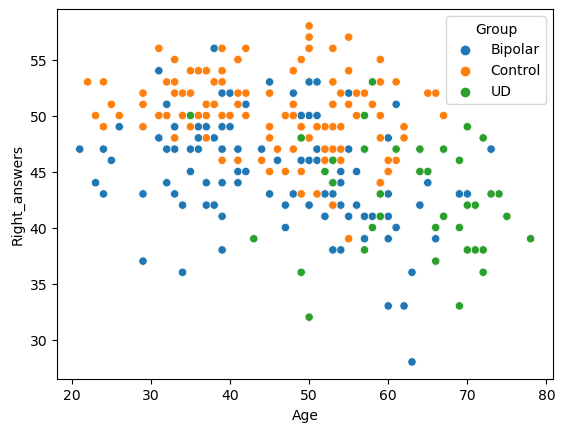

In [24]:
sns.scatterplot(data=df, x="Age", y="Right_answers", hue="Group")

It seems to be no linear relationship between the covariate and the independent variable levels. I will do ANCOVA just for programming practice but the results will not be taken into account.

In [25]:
pg.ancova(df, dv="Right_answers", covar="Age", between="Group")

,Source,SS,DF,F,p-unc,np2
0,Group,1635.583093,2,46.026076,5.953272e-18,0.252162
1,Age,421.820319,1,23.740444,1.871126e-06,0.080004
2,Residual,4850.665352,273,NaN,NaN,NaN


There may be an alternative konwn as the Johnson-Neyman Procedure (yet to be implemented)

Resource : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3203541/ (consulted 08/06/2023)

## Assessment scales between groups

### MANOVA

The hypothesises are as follow :

$$
\begin{cases}
H_0 : &  \text{The expected value of each scale is the same for every group} \\
H_1 : & \text{Alternative hypothesis}
\end {cases}
$$

In [26]:
dvs = [str(col) for col in df.columns[4:]]

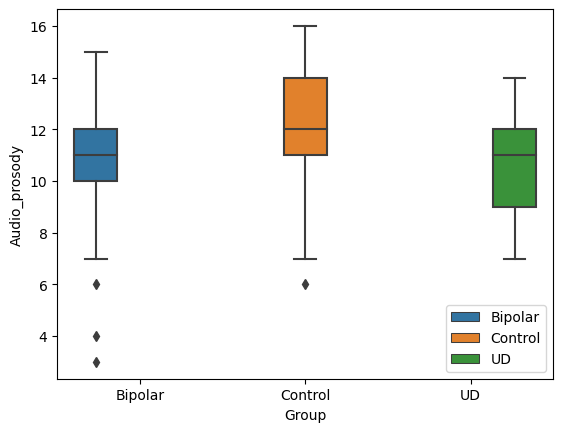

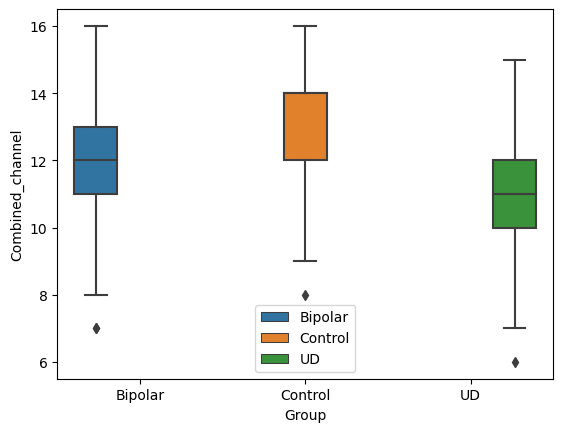

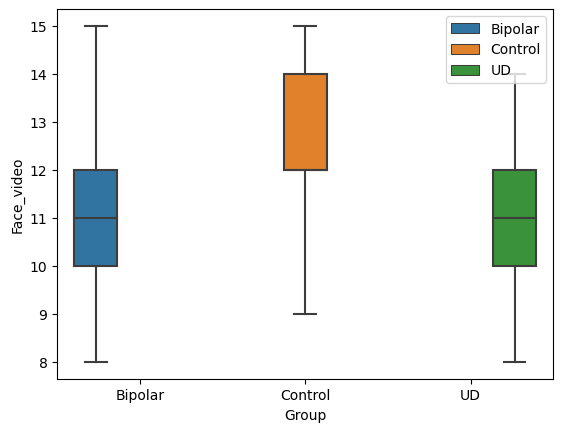

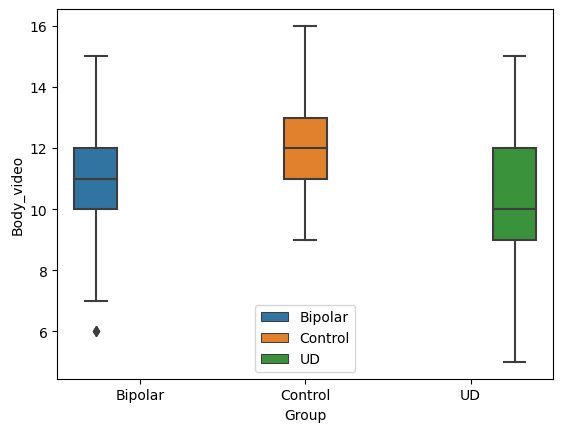

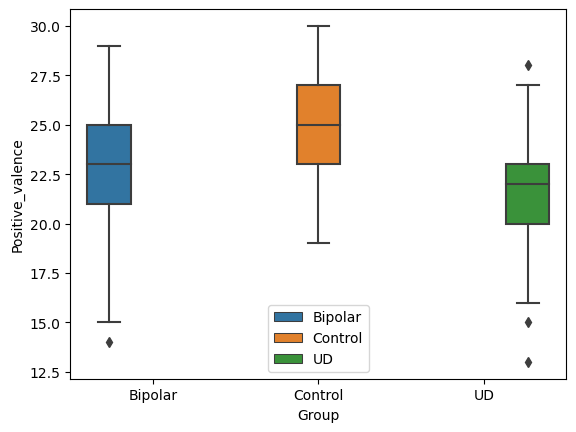

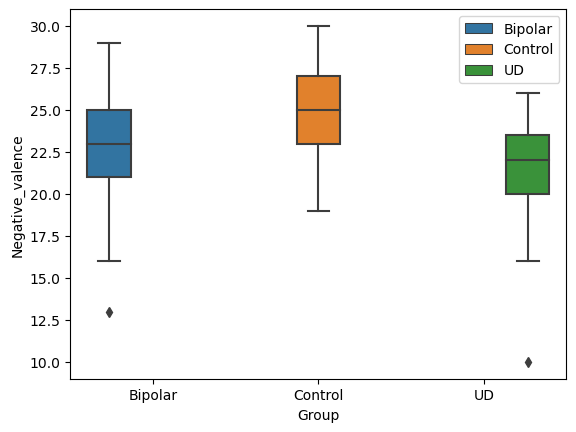

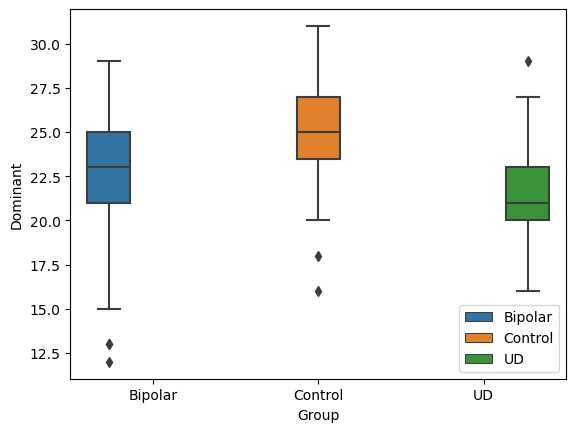

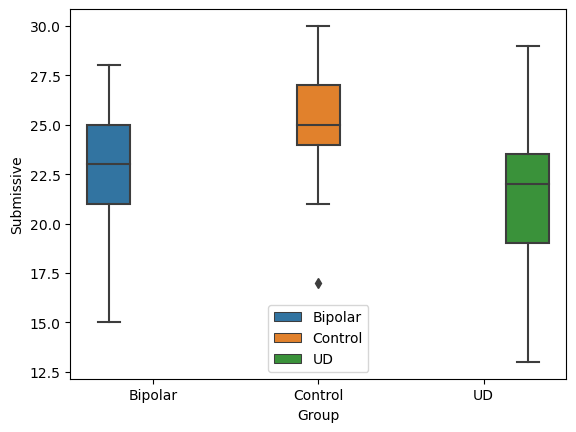

In [27]:
for v in dvs:
    g = sns.boxplot(data = df, x = "Group", y = v, hue = df.Group.to_list())
    plt.show()

It also seems that the control group is different from the two other on each scale. Much harder to tell between the other two once again.

#### Normality of each dependant variable

In [28]:
for v in dvs:
    print(f"\nShapiro-Wilk test results for {v}\n")
    tab = PrettyTable(["Group"," Statistic", "p-value"])
    pvalues = []

    for sample, group in zip(samples, groups):
        sample = df[v].loc[df.Group == group]
        shapiroTest = stats.shapiro(sample)
        pvalues.append(shapiroTest.pvalue)
        tab.add_row([f"{group} group", shapiroTest.statistic, shapiroTest.pvalue])

    print(tab)

    alphas = [5/100,1/100,1/1000]

    tab = PrettyTable(["Group", *[f"Rejetion of H_0 with alpha = {alpha}" for alpha in alphas]])
    for group, pvalue in zip(groups, pvalues):
        tab.add_row([f"{group} group", *[pvalue < alpha for alpha in alphas] ])
    
    print(tab)


Shapiro-Wilk test results for Audio_prosody

+---------------+--------------------+-----------------------+
|     Group     |      Statistic     |        p-value        |
+---------------+--------------------+-----------------------+
| Bipolar group | 0.9378482103347778 |  3.3117103157565e-05  |
| Control group | 0.9614118337631226 | 0.0017386958934366703 |
|    UD group   | 0.9391080141067505 |  0.03556045517325401  |
+---------------+--------------------+-----------------------+
+---------------+-----------------------------------+-----------------------------------+------------------------------------+
|     Group     | Rejetion of H_0 with alpha = 0.05 | Rejetion of H_0 with alpha = 0.01 | Rejetion of H_0 with alpha = 0.001 |
+---------------+-----------------------------------+-----------------------------------+------------------------------------+
| Bipolar group |                True               |                True               |                True                |
| Con

We see that the assumption of normaility for each dependent variable is not met for all alphas.

#### Equality of covariance matrices

In [29]:
print(f"\nBox'M test results")
tab = PrettyTable(["Statistic", "p-value"])

boxMTest = pg.box_m(df, dvs= dvs, group='Group')
print(boxMTest)
tab.add_row([boxMTest.Chi2, boxMTest.pval])
print(tab)
    
alphas = [5/100,1/100,1/1000]
    
tab = PrettyTable(["Alpha", f"Rejetion of H_0 with alpha"])
   
for alpha in alphas:  
    tab.add_row([alpha, boxMTest.pval < alpha])
    
print(tab)


Box'M test results
     Chi2    df  pval  equal_cov
box   NaN  72.0   NaN      False
+----------------------------+----------------------------+
|         Statistic          |          p-value           |
+----------------------------+----------------------------+
|         box   NaN          |         box   NaN          |
| Name: Chi2, dtype: float64 | Name: pval, dtype: float64 |
+----------------------------+----------------------------+
+-------+----------------------------+
| Alpha | Rejetion of H_0 with alpha |
+-------+----------------------------+
|  0.05 |        box    False        |
|       |  Name: pval, dtype: bool   |
|  0.01 |        box    False        |
|       |  Name: pval, dtype: bool   |
| 0.001 |        box    False        |
|       |  Name: pval, dtype: bool   |
+-------+----------------------------+


C:\Users\lucas\anaconda3\lib\site-packages\pingouin\multivariate.py:389: RuntimeWarning: invalid value encountered in log
  u = -2 * (1 - c) * np.log(M)


The test is failing because there is a least one of the sample covariance matrix which is not inversible. I have yet to find an other test for checking the equality between covariance matrices.

#### MANOVA results

In [30]:
formula = " + ".join(dvs) + " ~ Group"
manova_result = MANOVA.from_formula(formula, df)
print(manova_result.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.1462 6.0000 269.0000  261.9053 0.0000
         Pillai's trace  7.9741 6.0000 269.0000  -51.2618 1.0000
 Hotelling-Lawley trace 45.9216 6.0000 269.0000 2058.8187 0.0000
    Roy's greatest root 48.6104 6.0000 269.0000 2179.3649 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
          Group          Value   Num DF  Den DF  F Value  Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.0716 12.0000 538.0000 122.7458 0.0000
          Pillai's trace 1.2201 12.0000 540.0

MANOVA tells that there is a difference in expected values between the groups. However, with none of its assumptions met i will not consider these results trustworthy.

### Multivariate Kruskal-Willis test

Yet to be implemented. One ressource i have found : https://rdrr.io/github/jacobmaugoust/ULT/src/R/multkw.R (consulted 08/06/2023).